# Cul-de-sacs

Cul-de-sacs are a common feature of English towns and cities. So much so that often a significant proportion of the street network in a town is only of use to its immediate residents - it only provides access to and from the properties located on the cul-de-sac itself and doesn't contribute to the wider accessibility/permeability of the town. This is in strong contrast to gridded street networks where all streets are through streets.

Cul-de-sacs are often seen as desireable for the quiet environment that they create, keeping high-speed through traffic away from residential properties. Arguably however, cul-de-sacs are themselves responsible for this binary view of street types (quiet cul-de-sacs v. busy through roads) as new cul-de-sac developments do not contribute new through routes but do put greater and greater load onto those through routes that already exist.

This notebook:

1. uses OSMnx to download the street network for Bicester
2. recursively identifies street segments that are branches of a cul-de-sac
3. plots the results allowing the edge depth to be adjusted interactively

*Note: This notebook was developed in a miniforge environment on a Raspberry Pi 4 8GB running 64bit Raspberry Pi OS*

## 0. Required libraries and custom functions

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline
#ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
def prune_graph(G_):
    """
    Recursively removes nodes of degree 1 from a graph (here assumed to be cul-de-sacs).
    
    Parameters
    ----------
    G_ : initial graph
    
    Returns
    -------
    H_ : pruned graph
    """
    # empty set to hold nodes with a degree > 1
    node_set = set()
    
    # iterate through the nodes and their degrees
    for n,k in G_.degree():
        # if the degree of the node>1 add the node to the node_set
        if k > 1:
            node_set.add(n)

    # create H_, the subgraph of G_ formed of nodes with a degree greater than 1.
    H_ = G_.subgraph(node_set)
    
    # check if H_ is smaller than G_
    if len(H_.nodes) < len(G_.nodes):
        # if it is recursively prune the graph again
        return(prune_graph(H_))
    else:
        # if it isn't return the final pruned graph
        return(H_)

In [3]:
# Centre points of places
Alresford = (51.0884,-1.1649)
Bicester = (51.8968,-1.1517)

In [4]:
# Get the OSM street network for a place
G = ox.graph_from_point(center_point=Bicester, dist=2500, network_type="drive")

## It is important to get these the right way round - projection returns a DiGraph ##
# First, project the graph
G_prj = ox.project_graph(G)
# Second, convert the MultiDiGraph to an undirected MultiGraph
G_und_prj = ox.utils_graph.get_undirected(G_prj)
# Create a 'pruned' copy of the graph with all cul-de-sacs removed
G_pruned = prune_graph(G_und_prj)

In [5]:
# Check that the original graph is connected
nx.is_connected(G_und_prj)

True

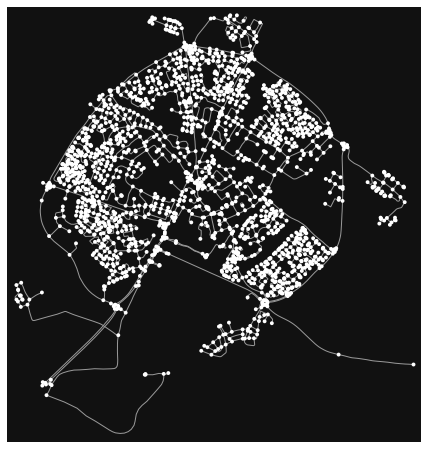

In [6]:
# Show initial results
fig, ax = ox.plot_graph(G_und_prj)

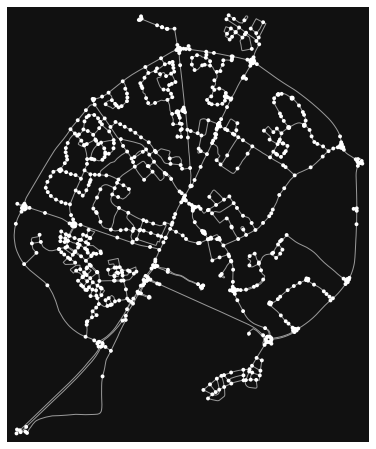

In [7]:
# Show initial results
fig, ax = ox.plot_graph(G_pruned)

## Calculate the depth of the cul-de-sac branches

In [8]:
# work with copies of the graphs
G_copy = G_und_prj.copy()
G_pruned_copy = G_pruned.copy()

In [9]:
# add "root" as a node in the original graph
G_copy.add_node("root")

# for every node in the pruned graph
for n in G_pruned_copy:
    # find its neighbours in the original graph
    nbrs = set(G_copy.neighbors(n))
    # for every neighbour that is not itself part of the pruned copy
    for nbr in nbrs - set(G_pruned_copy.nodes):
        # add an edge from "root" to the neighbour
        G_copy.add_edge("root",nbr)
    # then remove the node
    G_copy.remove_node(n)
    
# calculate the topological distance from root for the cul-de-sac nodes
node_depths_from_root = nx.shortest_path_length(G_copy,"root")

# to set the depth of every node in the original graph
# create an empty dict to hold ALL node depths
node_depths = dict()
# for every node in the original graph
for node in G_und_prj:
    # get its depth from the cul-de-sac node depths dict or the default of zero
    node_depths[node] = node_depths_from_root.get(node, 0)

# add the node depth as an attribute to the nodes of the original graph
nx.set_node_attributes(G_und_prj, node_depths, "node_depth")
# also set the edge depth to the maximum node depth of that edge
for n1, n2, e in G_und_prj.edges:
    G_und_prj[n1][n2][e]['edge_depth'] = max(G_und_prj.nodes[n1]['node_depth'],
                                             G_und_prj.nodes[n2]['node_depth'])

## Visualise intermediate results

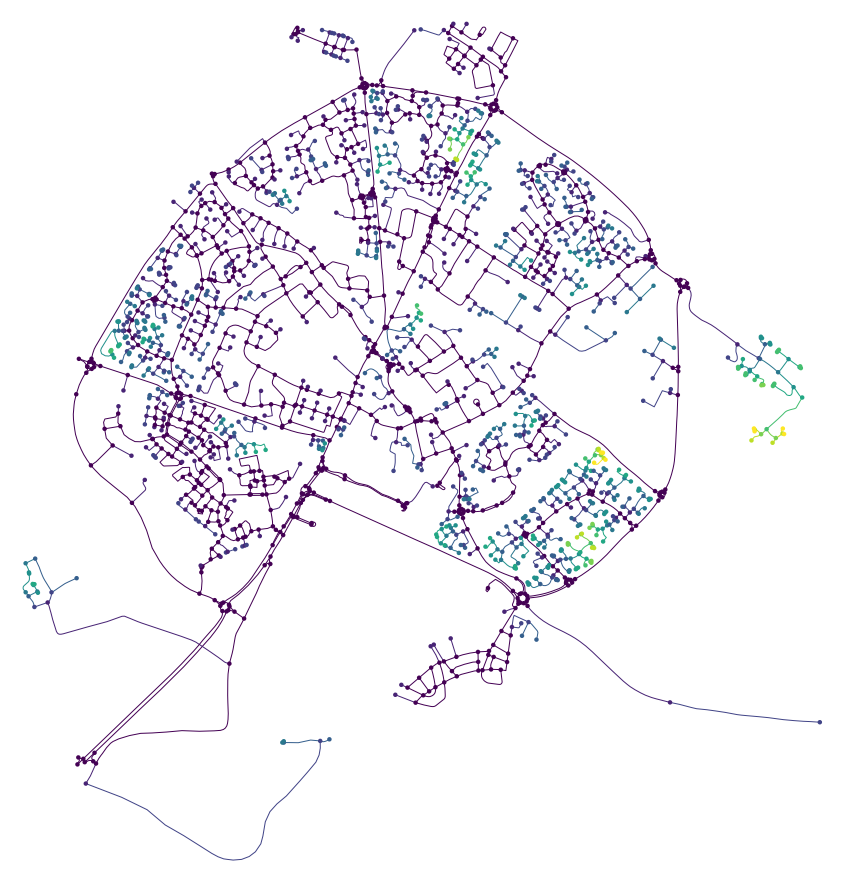

(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

In [11]:
# color nodes in original graph with the node depth
nd = ox.plot.get_node_colors_by_attr(G_und_prj, "node_depth", cmap="viridis")
# color edges in original graph with the edge depth
ed = ox.plot.get_edge_colors_by_attr(G_und_prj, "edge_depth", cmap="viridis")
# plot
fig, ax = plt.subplots(figsize=(16, 16))
ox.plot_graph(G_und_prj, ax=ax, node_color=nd, edge_color=ed, edge_linewidth=1, node_size=20)

## Convert the graph to a set of GeoDataFrames for use with Bokeh

In [12]:
# Convert the graph to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_und_prj)
# reproject to web mercator for overlaying with a base map
gdf_edges = gdf_edges.to_crs(epsg=3857)

In [13]:
# Reduce the number of columns to a minimum
gdf_edges = gdf_edges[['length', 'edge_depth', 'geometry']]
gdf_edges.head()

length  edge_depth  \
u      v        key                       
411817 411818   0    21.386           0   
       411819   0    22.383           0   
411818 411819   0    20.465           0   
       10610175 0    92.629           0   
411819 26444930 0    52.725           0   

                                                              geometry  
u      v        key                                                     
411817 411818   0    LINESTRING (-130242.112 6784063.736, -130237.7...  
       411819   0    LINESTRING (-130230.379 6784036.505, -130235.9...  
411818 411819   0    LINESTRING (-130213.614 6784059.044, -130212.5...  
       10610175 0    LINESTRING (-130069.957 6784101.541, -130095.0...  
411819 26444930 0    LINESTRING (-130207.804 6783957.647, -130219.5...

To be able to work with the filtering later on the data needs to be usable in Bokeh as a ColumnDataSource rather than a GeoDataSource, therefore it is necessary to extract the x and y coordinates out of the shapely geometries.

In [14]:
# Extract the x coordinates of the edges
xs = gdf_edges.apply(lambda x: [y for y in x['geometry'].coords.xy[0]], axis=1)
gdf_edges['xs']=xs
# Extract the y coordinates of the edges
ys = gdf_edges.apply(lambda x: [y for y in x['geometry'].coords.xy[1]], axis=1)
gdf_edges['ys']=ys

gdf_edges.head()

length  edge_depth  \
u      v        key                       
411817 411818   0    21.386           0   
       411819   0    22.383           0   
411818 411819   0    20.465           0   
       10610175 0    92.629           0   
411819 26444930 0    52.725           0   

                                                              geometry  \
u      v        key                                                      
411817 411818   0    LINESTRING (-130242.112 6784063.736, -130237.7...   
       411819   0    LINESTRING (-130230.379 6784036.505, -130235.9...   
411818 411819   0    LINESTRING (-130213.614 6784059.044, -130212.5...   
       10610175 0    LINESTRING (-130069.957 6784101.541, -130095.0...   
411819 26444930 0    LINESTRING (-130207.804 6783957.647, -130219.5...   

                                                                    xs  \
u      v        key                                                      
411817 411818   0    [-130242.11217187009, -130237.70392003452, -13...   
       411819   0    [-130230.3790975404, -130235.98959987646, -130...   
411818 411819   0    [-130213.61438222697, -130212.54571511534, -13...   
       10610175 0    [-130069.95657935813, -130095.0813884304, -130...   
411819 26444930 0    [-130207.80350480758, -130219.51431523888, -13...   

                                                                    ys  
u      v        key                                                     
411817 411818   0    [6784063.735519459, 6784067.48897585, 6784069....  
       411819   0    [6784036.504967216, 6784037.89446303, 6784040....  
411818 411819   0    [6784059.043701415, 6784053.341341602, 6784047...  
       10610175 0    [6784101.540844744, 6784091.254891522, 6784074...  
411819 26444930 0    [6783957.646959012, 6783974.302716961, 6783983...

At this point we have a clean table of edges ready for visualising with Bokeh. We can do a final check with GeoPandas and Matplotlib:

<AxesSubplot:>

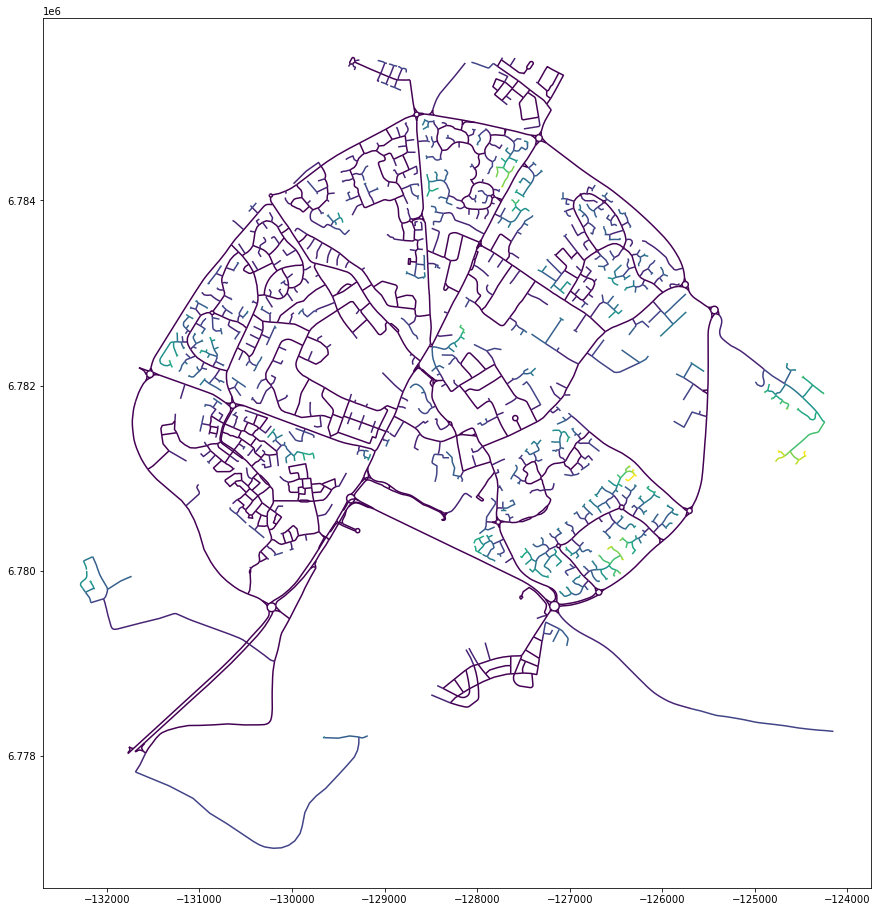

In [15]:
gdf_edges.plot(figsize=(16,16), column='edge_depth', cmap='viridis')

## Bokeh

In [16]:
from bokeh.plotting import output_file, figure, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource, ColorBar, Slider, CustomJS, CustomJSFilter, CDSView
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis10
from bokeh.layouts import column

In [31]:
output_file("cul_de_sac.html")

# Create the plot
p = figure(plot_height=750,
           plot_width=750,
           border_fill_color = "#eaeaf2",
           background_fill_color = "#eaeaf2",
           x_range=gdf_edges.total_bounds[[0,2]], # range bounds supplied in web mercator coordinates
           y_range=gdf_edges.total_bounds[[1,3]],
           x_axis_type="mercator", # generates axes with latitude and longitude labels
           y_axis_type="mercator"
          )

# Add background map tiles
tile_provider = get_provider(CARTODBPOSITRON)
p.add_tile(tile_provider)

# Create the color map and color bar
edge_mapper = linear_cmap(field_name='edge_depth', palette=Viridis10, low=0 ,high=10)
color_bar = ColorBar(color_mapper=edge_mapper['transform'], location=(0, 0), background_fill_color="#eaeaf2")
p.add_layout(color_bar, 'right')

# Slider section #
##################
# Convert DataFrames into ColumnDataSource
edges_source = ColumnDataSource(gdf_edges[['edge_depth', 'xs', 'ys']])

# Make a slider object to toggle the month shown
slider = Slider(start=0, end=10, value=0, step=1, title="Cul-de-sac depth", background="#eaeaf2")

# This callback triggers the filter when the slider changes
callback = CustomJS(args=dict(source=edges_source),
                    code="""source.change.emit();""")

slider.js_on_change('value', callback)

# Creates custom filter that selects the rows of the month based on the value in the slider
custom_filter = CustomJSFilter(args=dict(slider=slider, edges_source=edges_source),
                               code='''
    var indices = [];
    // iterate through rows of data source and see if each satisfies some constraint
    for (var i = 0; i < edges_source.get_length(); i++){
        if (edges_source.data['edge_depth'][i] <= slider.value){
            indices.push(true);
        } else {
            indices.push(false);
        }
    }
    return indices;
''')

view = CDSView(source=edges_source, filters=[custom_filter])

# Add the lines to the map from our 'msource' ColumnDataSource -object
# Add the lines to the map from our GeoJSONDataSource -object (it is important to specify the columns as 'xs' and 'ys')
edges = p.multi_line('xs', 'ys', source=edges_source, line_color=edge_mapper,
             color=edge_mapper, line_width=3, view=view)

# End of slider section #
#########################

layout = column(p, slider)

show(layout)